In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px

from matplotlib import pyplot as plt

## Import Data

In [2]:
df = pd.read_json('cleaned_data.json')
condo_df = df[df['Type'] == 'Condo']
house_df = df[df['Type'] == 'House']
df.head()

,Name,Address,Author,Price,Bedrooms,Showers,Parking,Furnish,Total Developed,Features,...,Nearby Places,URL,Timestamp,City,Region,Island,Type,NFeatures,NFacilities,NNearby Places
0,"3 BR Condo in The Grand Midori Ortigas, Pasig",,"Federal Land, Inc.",29700000,3,3.0,2,0,107.0,"[Ensuite, Range Hood, Stove/Burner]",...,"[School, Hospital]",https://propertyaccess.ph/property/3-br-condo-...,2022-10-23,Pasig,National Capital Region,Luzon,Condo,3,11,2
1,"1 Bedroom Condo in The Grand Midori Ortigas, P...",,"Federal Land, Inc.",10200000,1,1.0,0,0,46.0,[Fiber ready],...,"[School, Hospital]",https://propertyaccess.ph/property/1br-condo-i...,2022-10-23,Pasig,National Capital Region,Luzon,Condo,1,11,2
2,"3 Bedroom Condo in Aurelia Residences, Taguig","McKinley Parkway, Taguig, Metro Manila",Shang Properties,107300000,3,4.0,2,0,242.0,"[Central air conditioning, Balcony, Built-in w...",...,"[School, Hospital, Mall, Transportation hub]",https://propertyaccess.ph/property/3-bedroom-c...,2022-10-23,Taguig,National Capital Region,Luzon,Condo,10,15,4
3,3 Bedroom Condo in Shang Residences at Wack Wa...,"Wack Wack Road, Mandaluyong, Metro Manila",Shang Properties,54500000,3,4.0,3,0,231.0,"[Central air conditioning, Balcony, Built-in w...",...,"[School, Hospital, Mall, Transportation hub]",https://propertyaccess.ph/property/3-bedroom-c...,2022-10-23,Mandaluyong,National Capital Region,Luzon,Condo,9,16,4
4,"2BR Condo in Residences at The Galleon, Pasig",,Ortigas Land,41500000,2,2.0,2,0,109.0,"[Central air conditioning, Balcony, Built-in w...",...,"[School, Hospital, Mall, Transportation hub]",https://propertyaccess.ph/property/2br-condo-i...,2022-10-23,Pasig,National Capital Region,Luzon,Condo,7,14,4


In [3]:
# data to be used for clustering
data = df[['Price', 'Bedrooms', 'Showers', 'Parking', 'Total Developed']]
condo_data = condo_df[['Price', 'Bedrooms', 'Showers', 'Parking', 'Total Developed']]
house_data = house_df[['Price', 'Bedrooms', 'Showers', 'Parking', 'Total Developed']]

## Exploratory Data Analysis

### Condos vs Houses

<AxesSubplot:title={'center':'Amount of Condos vs Houses'}, xlabel='Name', ylabel='Type'>

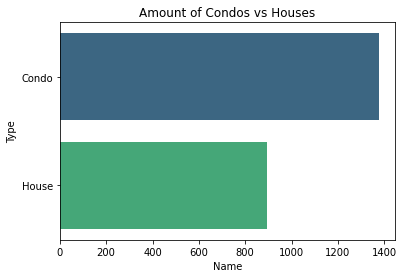

In [5]:
plt.title('Amount of Condos vs Houses')
sns.barplot(data=df.groupby('Type').count().reset_index(), x='Name', y='Type', palette='viridis')

<AxesSubplot:title={'center':'Price Range of Condos vs Houses'}, xlabel='Price', ylabel='Type'>

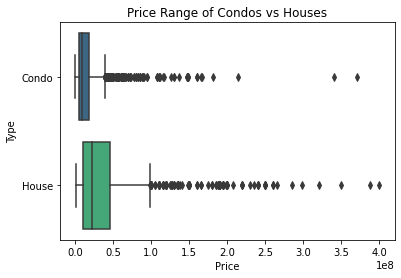

In [4]:
plt.title('Price Range of Condos vs Houses')
sns.boxplot(data=df, x='Price', y='Type', palette='viridis')

## Gaussian Mixture Model
https://machinelearningmastery.com/clustering-algorithms-with-python/

In [54]:
from matplotlib.patches import Ellipse

def draw_ellipse(gmm, n, ax=None, **kwargs):
    ax = ax or plt.gca()
    covariances = gmm.covariances_[n][:2, :2]
    v, w = np.linalg.eigh(covariances)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan2(u[1], u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    ell = Ellipse(gmm.means_[n, :2], v[0], v[1], 180 + angle)
    ell.set_clip_box(ax.bbox)
    ell.set_alpha(0.5)
    ax.add_artist(ell)
    ax.set_aspect("equal", "datalim")

### Condos

672 6728731.584821428
10 37433726.4
2 355000000.0
239 50774718.41841004
453 14915328.584988963


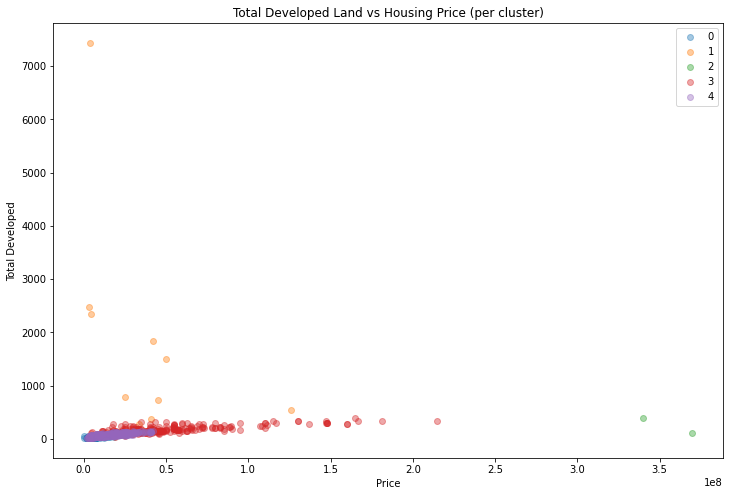

In [58]:
from sklearn.mixture import GaussianMixture
# define the model
model = GaussianMixture(n_components=5, covariance_type='full', random_state=1).fit(condo_data)
# assign a cluster to each example
yhat = model.predict(condo_data)

_ = plt.figure(figsize=(12, 8))
# retrieve unique clusters
clusters = np.unique(yhat)
# create scatter plot for samples from each cluster
for cluster in clusters:
    # get rows that exists in each cluster
    row = condo_data[yhat == cluster]
    print(len(row), row['Price'].mean())
    # create scatter of these samples
    ax = plt.scatter(row['Price'], row['Total Developed'], alpha=0.4, zorder=2)
    
plt.title("Total Developed Land vs Housing Price (per cluster)")
plt.xlabel("Price")
plt.ylabel("Total Developed")
plt.legend(clusters)
# show the plot
plt.show()

#### Compare Clusters

Text(0, 0.5, 'Count')

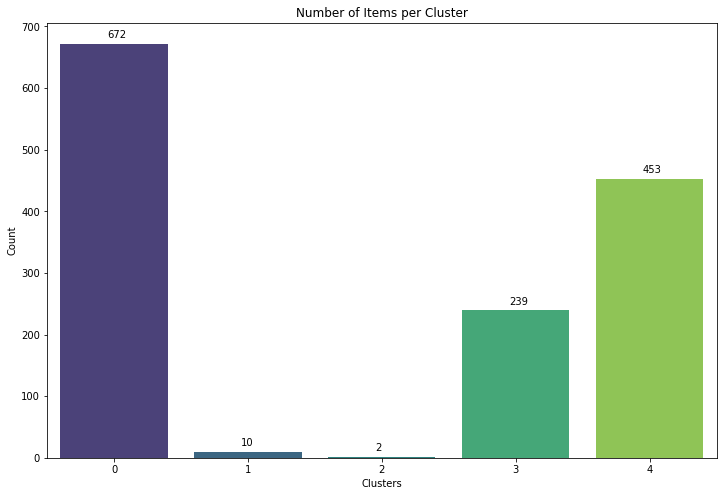

In [111]:
gaussianDF = condo_df.copy()

gaussianDF['Cluster'] = yhat

_ = plt.figure(figsize=(12, 8))

g = sns.countplot(x='Cluster', data=gaussianDF, palette='viridis')
for p in g.patches:
    g.annotate('{}'.format(p.get_height()), (p.get_x()+.35, p.get_height()+10))

plt.title("Number of Items per Cluster")
plt.xlabel("Clusters")
plt.ylabel("Count")

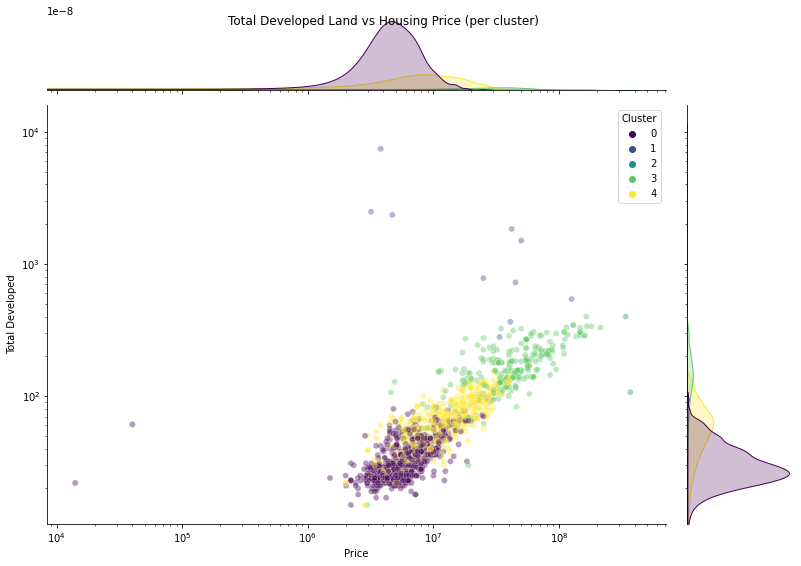

In [91]:
g = sns.jointplot(data=gaussianDF, x="Price", y="Total Developed", alpha=0.4, hue="Cluster", palette='viridis')

g.fig.suptitle("Total Developed Land vs Housing Price (per cluster)")
g.fig.set_size_inches((12, 8)) 
g.ax_joint.set_xscale('log')
g.ax_joint.set_yscale('log')

Text(0.5, 1.0, 'Prices per Cluster')

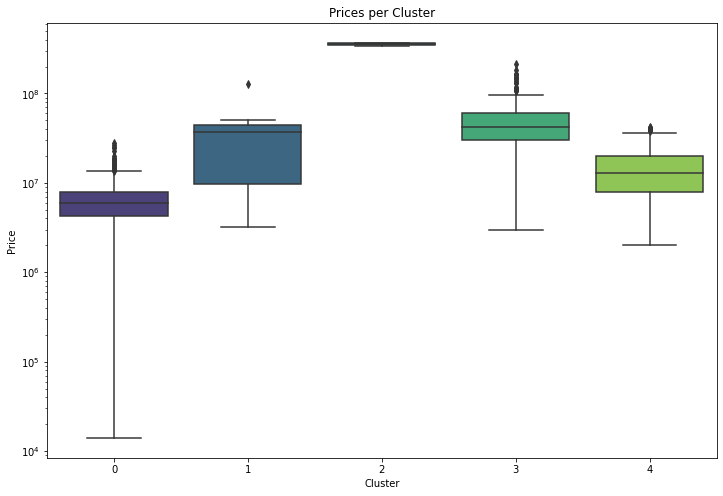

In [118]:
fig, ax= plt.subplots(figsize=(12, 8))
ax.set_yscale('log')
sns.boxplot(data=gaussianDF, x='Cluster', y='Price', palette='viridis', ax=ax)
plt.title("Prices per Cluster")

<AxesSubplot:title={'center':'Total Developed per Cluster'}, xlabel='Cluster', ylabel='Total Developed'>

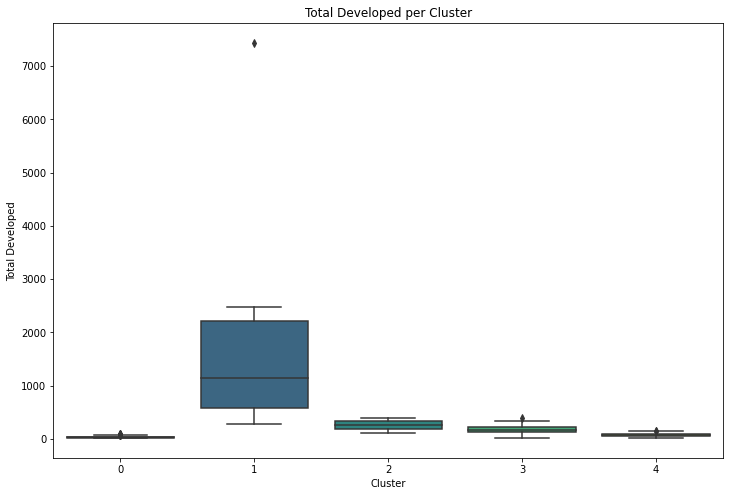

In [113]:
_ = plt.figure(figsize=(12, 8))

plt.title("Total Developed per Cluster")
sns.boxplot(data=gaussianDF, x='Cluster', y='Total Developed', palette='viridis')

### Houses

201 6038399.119402985
189 89954541.96296297
91 79597857.41758242
406 23518384.916256156
6 340216666.6666667


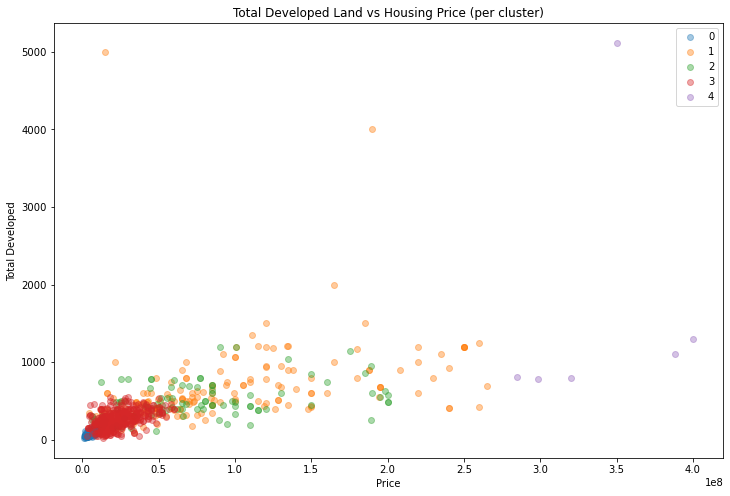

In [11]:
from sklearn.mixture import GaussianMixture
# define the model
model = GaussianMixture(n_components=5, random_state=3)
# fit the model
model.fit(house_data)
# assign a cluster to each example
yhat = model.predict(house_data)

_ = plt.figure(figsize=(12, 8))

# retrieve unique clusters
clusters = np.unique(yhat)
# create scatter plot for samples from each cluster
for cluster in clusters:
    # get rows that exists in each cluster
    row = house_data[yhat == cluster]
    print(len(row), row['Price'].mean())
    # create scatter of these samples
    plt.scatter(row['Price'], row['Total Developed'], alpha=0.4)
    
plt.title("Total Developed Land vs Housing Price (per cluster)")
plt.xlabel("Price")
plt.ylabel("Total Developed")
plt.legend(clusters)
# show the plot
plt.show()

#### Compare Clusters

Text(0, 0.5, 'Count')

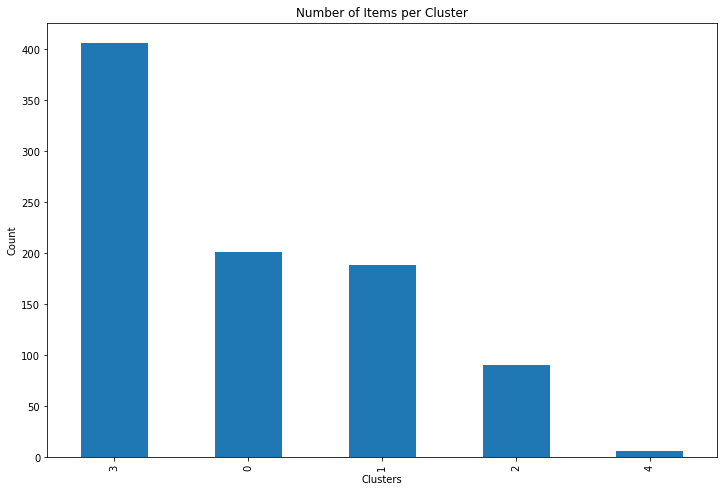

In [12]:
gaussianDF = house_df.copy()

gaussianDF['Cluster'] = yhat

_ = plt.figure(figsize=(12, 8))

gaussianDF['Cluster'].value_counts().plot(kind='bar')

plt.title("Number of Items per Cluster")
plt.xlabel("Clusters")
plt.ylabel("Count")

<AxesSubplot:title={'center':'Prices per Cluster'}, xlabel='Cluster', ylabel='Price'>

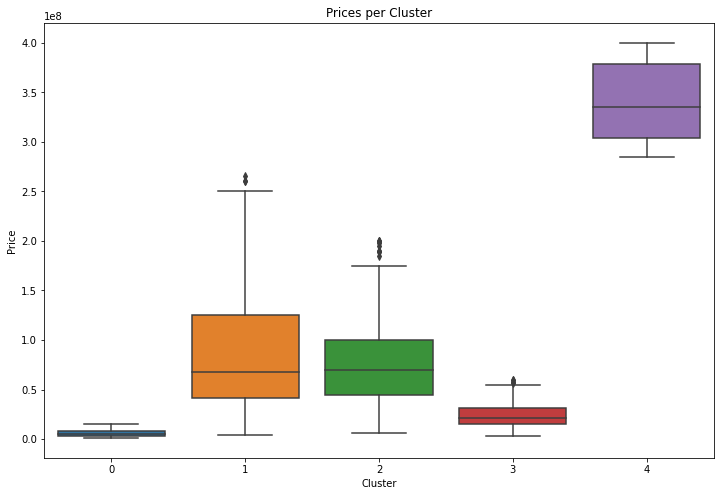

In [13]:
_ = plt.figure(figsize=(12, 8))

plt.title("Prices per Cluster")
sns.boxplot(data=gaussianDF, x='Cluster', y='Price')

<AxesSubplot:title={'center':'Total Developed per Cluster'}, xlabel='Cluster', ylabel='Total Developed'>

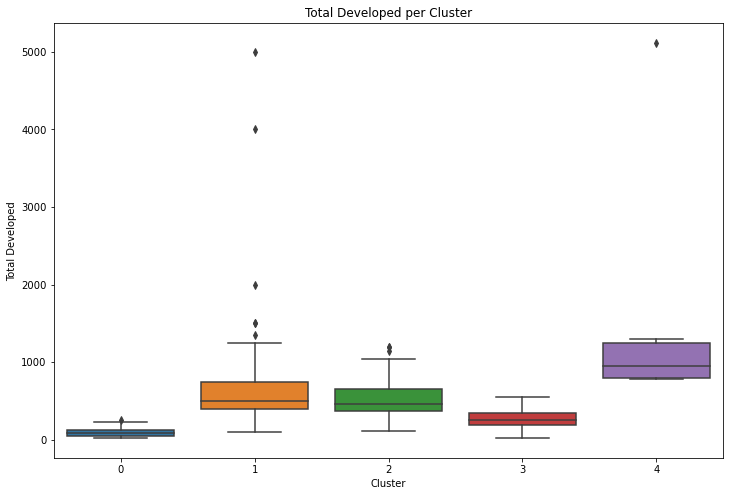

In [14]:
_ = plt.figure(figsize=(12, 8))

plt.title("Total Developed per Cluster")
sns.boxplot(data=gaussianDF, x='Cluster', y='Total Developed')

### Combined

941 25020026.98299681
18 169093666.66666666
1035 7616232.893719806
267 91103033.55430712
8 343912500.0


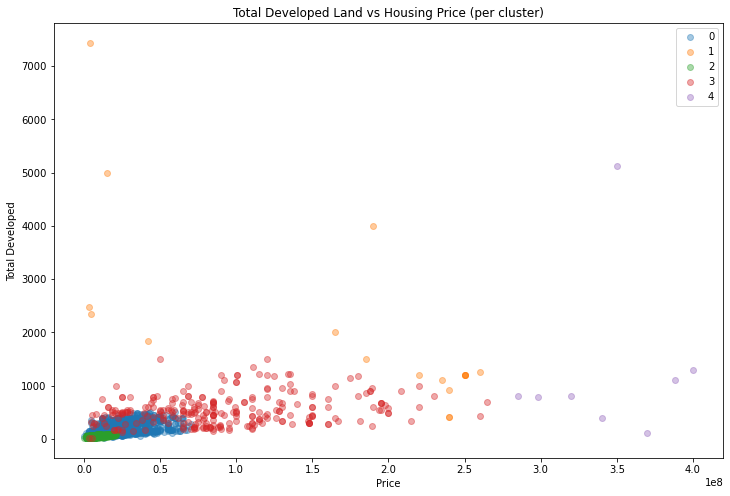

In [15]:
from sklearn.mixture import GaussianMixture
# define the model
model = GaussianMixture(n_components=5, random_state=6)
# fit the model
model.fit(data)
# assign a cluster to each example
yhat = model.predict(data)

_ = plt.figure(figsize=(12, 8))

# retrieve unique clusters
clusters = np.unique(yhat)
# create scatter plot for samples from each cluster
for cluster in clusters:
    # get rows that exists in each cluster
    row = data[yhat == cluster]
    print(len(row), row['Price'].mean())
    # create scatter of these samples
    plt.scatter(row['Price'], row['Total Developed'], alpha=0.4)
    
plt.title("Total Developed Land vs Housing Price (per cluster)")
plt.xlabel("Price")
plt.ylabel("Total Developed")
plt.legend(clusters)
# show the plot
plt.show()

#### Compare Clusters

Text(0, 0.5, 'Count')

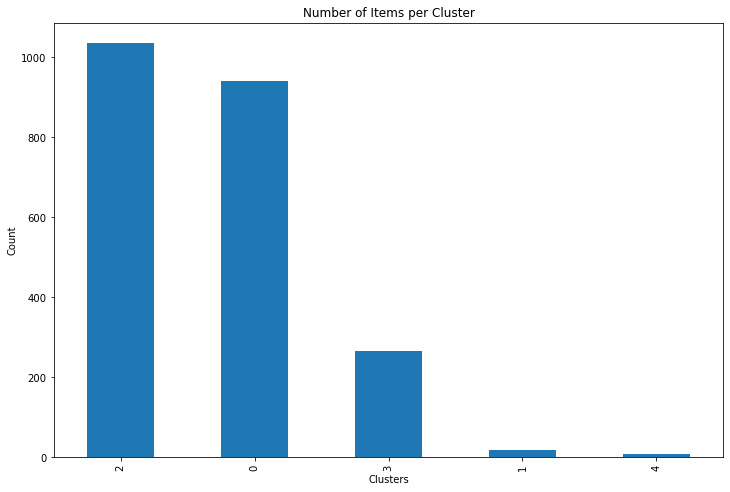

In [16]:
gaussianDF = df.copy()

gaussianDF['Cluster'] = yhat

_ = plt.figure(figsize=(12, 8))

gaussianDF['Cluster'].value_counts().plot(kind='bar')

plt.title("Number of Items per Cluster")
plt.xlabel("Clusters")
plt.ylabel("Count")

<AxesSubplot:title={'center':'Prices per Cluster'}, xlabel='Cluster', ylabel='Price'>

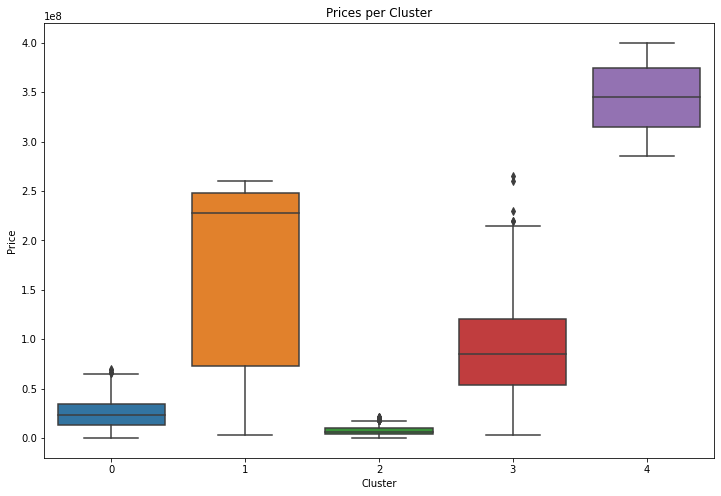

In [17]:
_ = plt.figure(figsize=(12, 8))

plt.title("Prices per Cluster")
sns.boxplot(data=gaussianDF, x='Cluster', y='Price')

<AxesSubplot:title={'center':'Total Developed per Cluster'}, xlabel='Cluster', ylabel='Total Developed'>

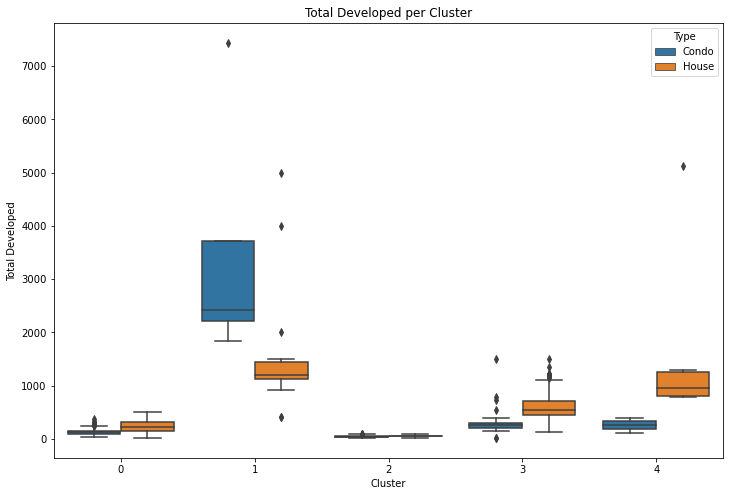

In [18]:
_ = plt.figure(figsize=(12, 8))

plt.title("Total Developed per Cluster")
sns.boxplot(data=gaussianDF, x='Cluster', y='Total Developed', hue='Type')

<AxesSubplot:xlabel='Name', ylabel='Region'>

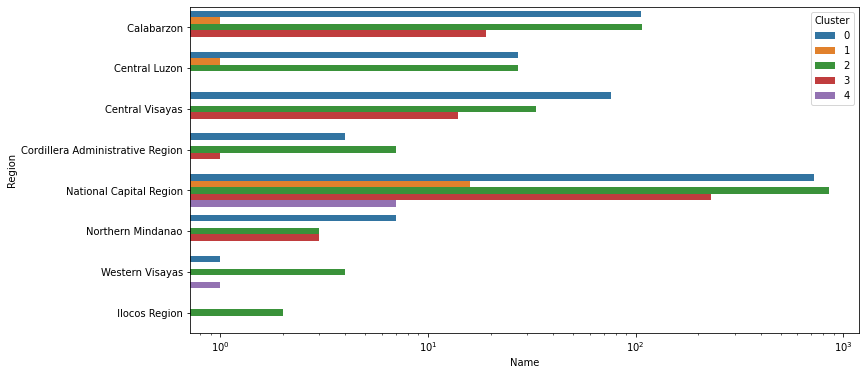

In [19]:
_ = plt.figure(figsize=(12, 6))

sns.barplot(data=gaussianDF.groupby(['Cluster', 'Region']).count()['Name'].reset_index(), x='Name', y='Region', hue='Cluster', log=True)

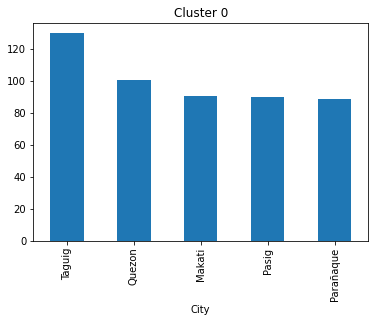

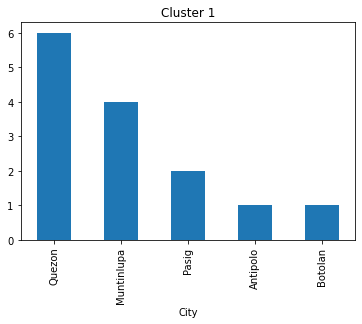

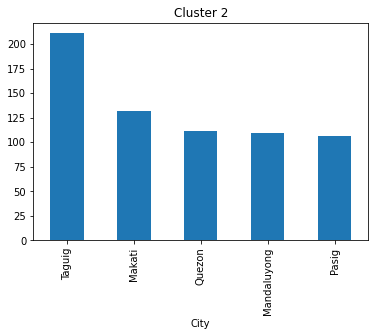

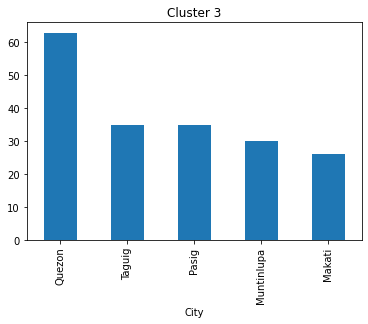

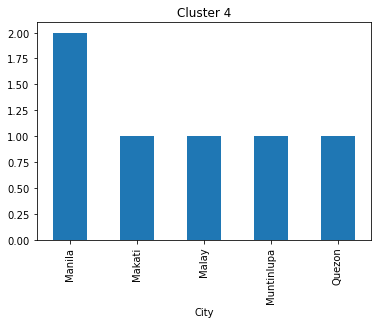

In [20]:
for cluster in clusters:
    _ = plt.figure(figsize=(6, 4))
    
    plt.title("Cluster %d" % cluster)
    gaussianDF[gaussianDF['Cluster'] == cluster].groupby('City').count()['Name'].sort_values(ascending=False).head(5).plot(kind="bar")

## k means clustering

In [21]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

In [22]:
scaler = MinMaxScaler()

### Condos

In [23]:
condo_scaled = condo_data.copy()
condo_scaled[condo_scaled.columns] = scaler.fit_transform(condo_data)
condo_scaled.head()

,Price,Bedrooms,Showers,Parking,Total Developed
0,0.080235,0.222222,0.50,0.50,0.012391
1,0.027531,0.000000,0.00,0.00,0.004175
2,0.289973,0.222222,0.75,0.50,0.030572
3,0.147265,0.222222,0.75,0.75,0.029091
4,0.112129,0.111111,0.25,0.50,0.012660


In [24]:
num_clusters = np.arange(2,20)

sum_of_squared_errors = []
silhouette = []
chi = []
dbi = []

for k in num_clusters:
    km = KMeans(n_clusters=k, random_state=42)
    km = km.fit(condo_scaled)
    sum_of_squared_errors.append(km.inertia_)
    
    labels = km.labels_
    silhouette.append(silhouette_score(condo_scaled, labels, metric='euclidean'))
    chi.append(calinski_harabasz_score(condo_scaled, labels))
    dbi.append(davies_bouldin_score(condo_scaled, labels))

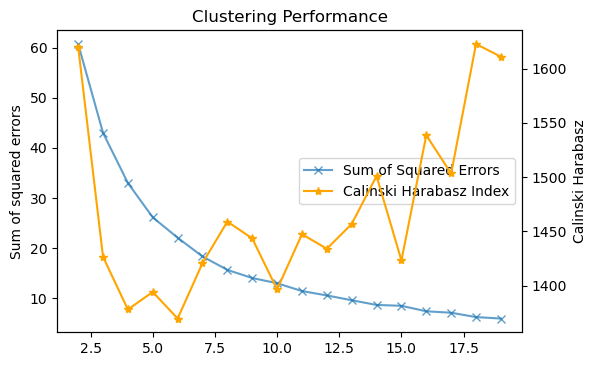

In [25]:
alpha = 0.7
fig, ax = plt.subplots(1,1, dpi=100)
lns1 = ax.plot(num_clusters, sum_of_squared_errors, 'x-', alpha=alpha, label='Sum of Squared Errors')
ax.set_ylabel('Sum of squared errors')

ax2 = ax.twinx()
ax2.set_ylabel('Calinski Harabasz')
ax2.grid(False)
lns2 = ax2.plot(num_clusters, chi, '*-', color='orange', label='Calinski Harabasz Index')

lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=5)

plt.xlabel('k')
plt.title('Clustering Performance')
plt.show()

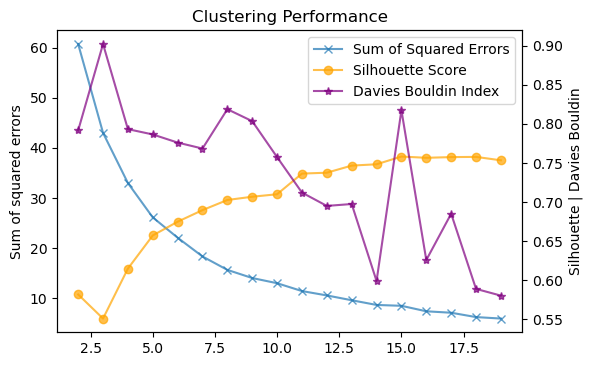

In [26]:
alpha = 0.7
fig, ax = plt.subplots(1,1, dpi=100)
lns1 = ax.plot(num_clusters, sum_of_squared_errors, 'x-', alpha=alpha, label='Sum of Squared Errors')
ax.set_ylabel('Sum of squared errors')

ax2 = ax.twinx()
ax2.set_ylabel('Silhouette | Davies Bouldin')
ax2.grid(False)
lns2 = ax2.plot(num_clusters, silhouette, 'o-', color='orange', alpha=alpha, label='Silhouette Score')
lns3 = ax2.plot(num_clusters, dbi, '*-', color='purple', alpha=alpha, label='Davies Bouldin Index')

lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)

plt.xlabel('k')
plt.title('Clustering Performance')
plt.show()

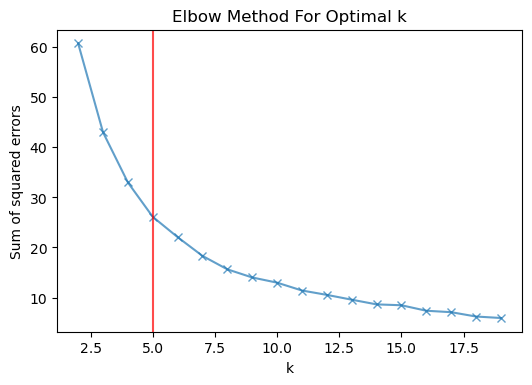

In [27]:
alpha = 0.7
fig, ax = plt.subplots(1,1, dpi=100)
lns1 = ax.plot(num_clusters, sum_of_squared_errors, 'x-', alpha=alpha, label='Sum of Squared Errors')
ax.set_ylabel('Sum of squared errors')

plt.axvline(5, color='red', alpha=alpha)
plt.xlabel('k')
plt.title('Elbow Method For Optimal k')
plt.show()

**Note:** we will use 5 clusters for the condos, houses, and combined

In [28]:
km = KMeans(n_clusters=5, random_state=25)
km = km.fit(condo_scaled)
clusters = km.fit_predict(condo_scaled)
condo_scaled['cluster'] = clusters

#### Compare Clusters

/Users/adem/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'Total Developed Land vs Housing Price (per cluster) - Condos'}, xlabel='Price', ylabel='Total Developed'>

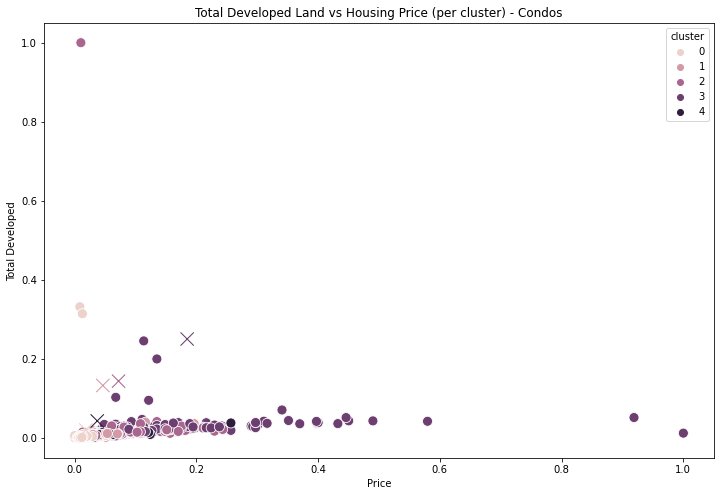

In [29]:
plt.figure(figsize=(12,8))
sns.scatterplot(data=condo_scaled,s=100, x='Price', y='Total Developed', hue='cluster').set(title='Total Developed Land vs Housing Price (per cluster) - Condos')
sns.scatterplot(km.cluster_centers_[:,0],km.cluster_centers_[:,1],s=175,hue=range(5), legend=False, marker='x')

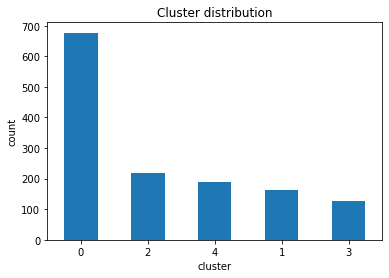

In [30]:
fig, ax = plt.subplots(1,1)
condo_scaled['cluster'].value_counts().plot(kind='bar', ax=ax)
plt.xticks(rotation=0)
plt.ylabel('count')
plt.xlabel('cluster')
plt.title('Cluster distribution')
plt.show()

<AxesSubplot:xlabel='cluster', ylabel='Price'>

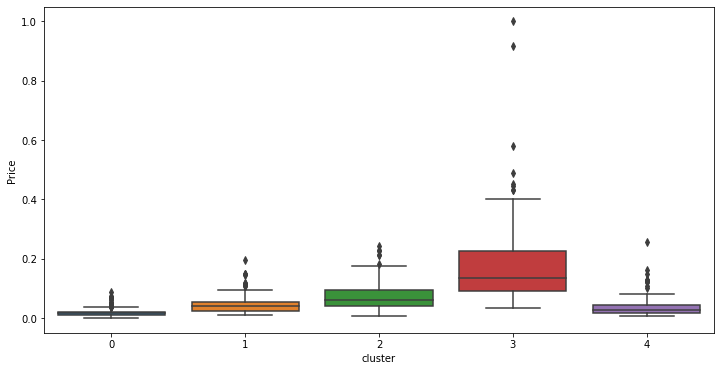

In [31]:
_ = plt.figure(figsize=(12, 6))

sns.boxplot(data=condo_scaled, x='cluster', y='Price')

<AxesSubplot:xlabel='cluster', ylabel='Total Developed'>

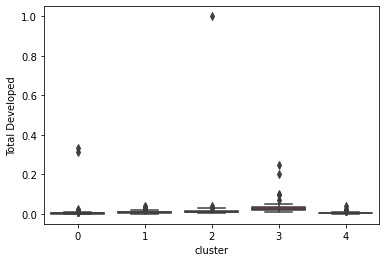

In [32]:
sns.boxplot(data=condo_scaled, x='cluster', y='Total Developed')

#### Condo not normalized

In [35]:
km = KMeans(n_clusters=5, random_state=25)
km = km.fit(condo_data)
clusters = km.fit_predict(condo_data)
condo_data['cluster'] = clusters

/var/folders/b5/583sbyw12yqf8bss252d8ndc0000gn/T/ipykernel_5431/1531273672.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  condo_data['cluster'] = clusters


/Users/adem/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'Total Developed Land vs Housing Price (per cluster) - Condos'}, xlabel='Price', ylabel='Total Developed'>

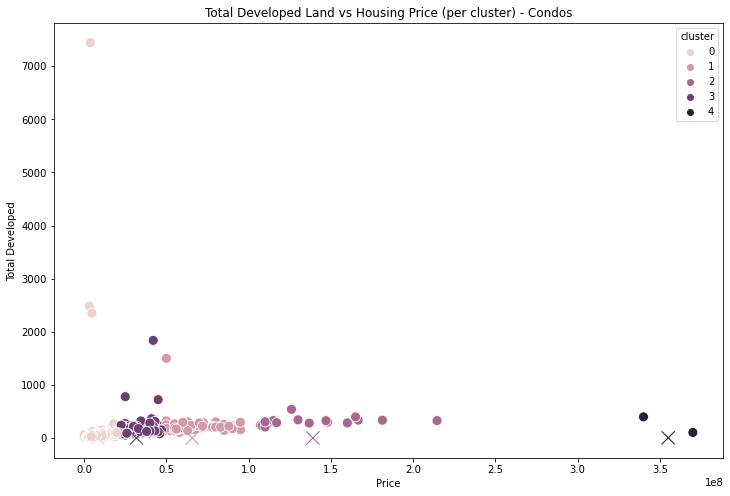

In [40]:
plt.figure(figsize=(12,8))
sns.scatterplot(data=condo_data,s=100, x='Price', y='Total Developed', hue='cluster').set(title='Total Developed Land vs Housing Price (per cluster) - Condos')
sns.scatterplot(km.cluster_centers_[:,0],km.cluster_centers_[:,1],s=175,hue=range(5), legend=False, marker='x')

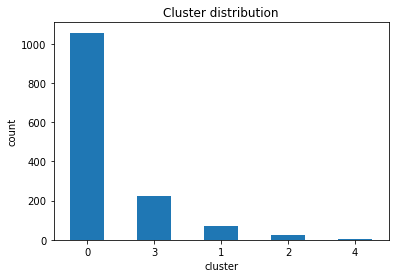

In [41]:
fig, ax = plt.subplots(1,1)
condo_data['cluster'].value_counts().plot(kind='bar', ax=ax)
plt.xticks(rotation=0)
plt.ylabel('count')
plt.xlabel('cluster')
plt.title('Cluster distribution')
plt.show()

<AxesSubplot:xlabel='cluster', ylabel='Price'>

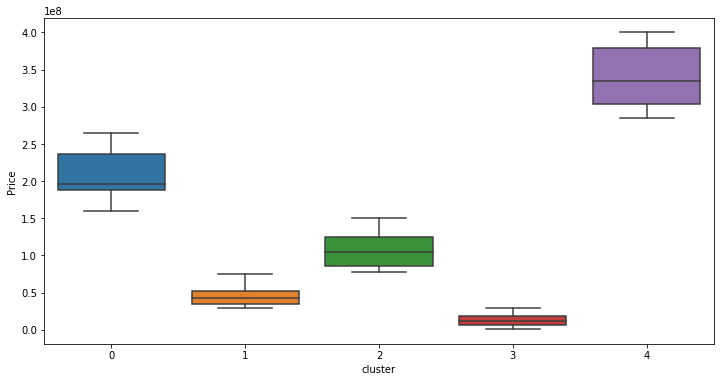

In [38]:
_ = plt.figure(figsize=(12, 6))

sns.boxplot(data=house_data, x='cluster', y='Price')

<AxesSubplot:xlabel='cluster', ylabel='Total Developed'>

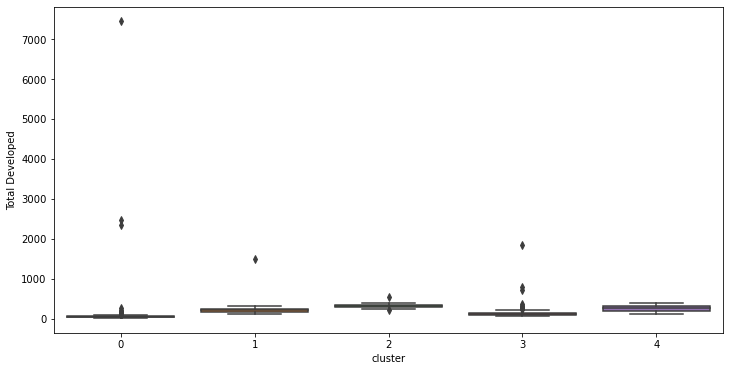

In [42]:
_ = plt.figure(figsize=(12, 6))
sns.boxplot(data=condo_data, x='cluster', y='Total Developed')

### Houses

In [28]:
house_scaled = house_data.copy()
house_scaled[house_scaled.columns] = scaler.fit_transform(house_data)
house_scaled.head()

,Price,Bedrooms,Showers,Parking,Total Developed,cluster
50,0.017298,0.000000,0.00,0.333333,0.026104,0.75
53,0.028579,0.444444,0.50,0.333333,0.031796,0.75
54,0.043186,0.111111,0.25,0.333333,0.029048,0.75
55,0.104490,0.333333,0.75,0.333333,0.047498,0.25
58,0.161742,0.333333,0.75,0.333333,0.054956,0.25


In [29]:
km = KMeans(n_clusters=5, random_state=25)
km = km.fit(house_scaled)
clusters = km.fit_predict(house_scaled)
house_scaled['cluster'] = clusters

#### Compare Clusters

/Users/adem/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'Total Developed Land vs Housing Price (per cluster) - Houses'}, xlabel='Price', ylabel='Total Developed'>

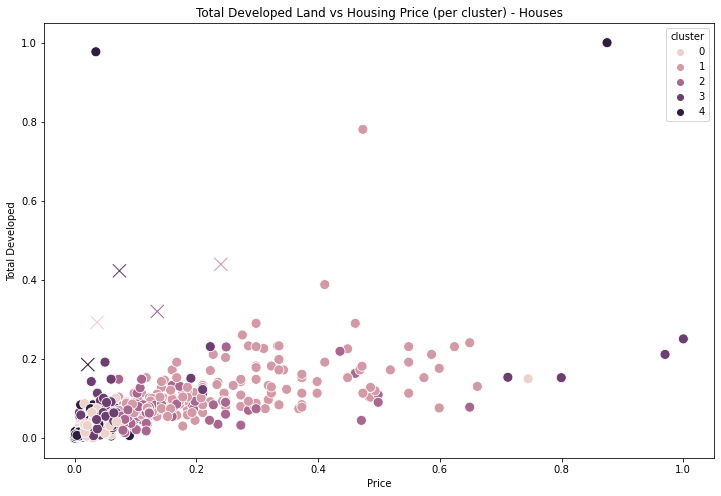

In [30]:
plt.figure(figsize=(12,8))
sns.scatterplot(data=house_scaled,s=100, x='Price', y='Total Developed', hue='cluster').set(title='Total Developed Land vs Housing Price (per cluster) - Houses')
sns.scatterplot(km.cluster_centers_[:,0],km.cluster_centers_[:,1],s=175,hue=range(5), legend=False, marker='x')

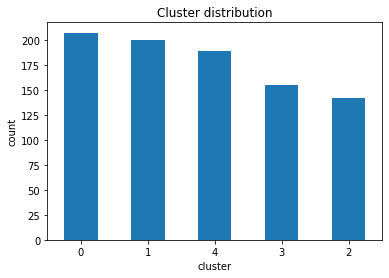

In [31]:
fig, ax = plt.subplots(1,1)
house_scaled['cluster'].value_counts().plot(kind='bar', ax=ax)
plt.xticks(rotation=0)
plt.ylabel('count')
plt.xlabel('cluster')
plt.title('Cluster distribution')
plt.show()

<AxesSubplot:xlabel='cluster', ylabel='Price'>

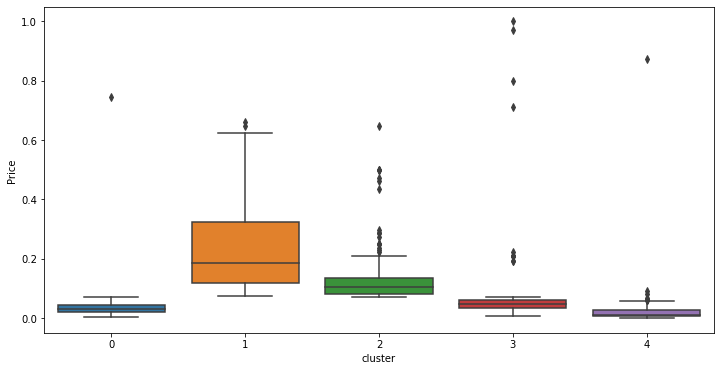

In [32]:
_ = plt.figure(figsize=(12, 6))

sns.boxplot(data=house_scaled, x='cluster', y='Price')

<AxesSubplot:xlabel='cluster', ylabel='Total Developed'>

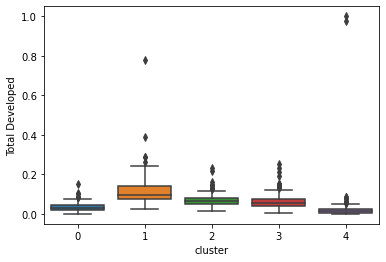

In [33]:
sns.boxplot(data=house_scaled, x='cluster', y='Total Developed')

#### Actual values

In [22]:
km = KMeans(n_clusters=5, random_state=25)
km = km.fit(house_data)
clusters = km.fit_predict(house_data)
house_data['cluster'] = clusters

/var/folders/b5/583sbyw12yqf8bss252d8ndc0000gn/T/ipykernel_5431/1206392037.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  house_data['cluster'] = clusters


/Users/adem/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'Total Developed Land vs Housing Price (per cluster) - Houses'}, xlabel='Price', ylabel='Total Developed'>

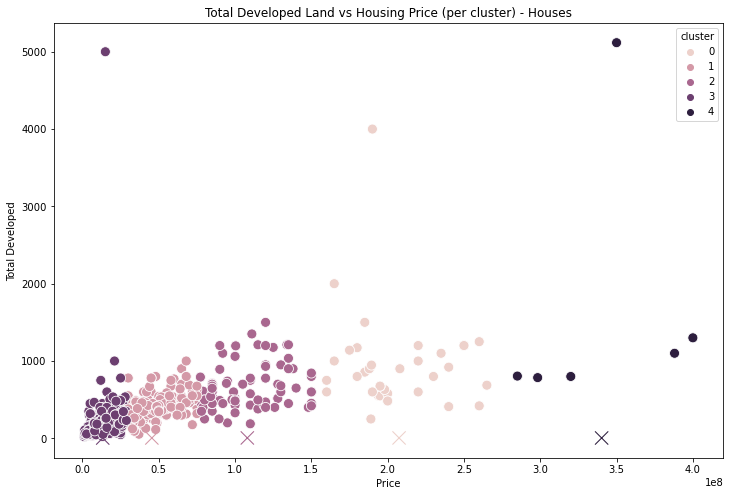

In [23]:
plt.figure(figsize=(12,8))
sns.scatterplot(data=house_data,s=100, x='Price', y='Total Developed', hue='cluster').set(title='Total Developed Land vs Housing Price (per cluster) - Houses')
sns.scatterplot(km.cluster_centers_[:,0],km.cluster_centers_[:,1],s=175,hue=range(5), legend=False, marker='x')

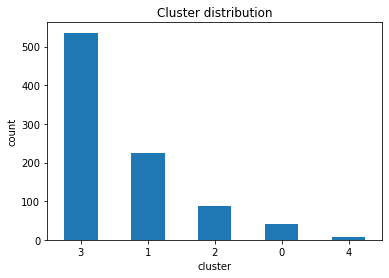

In [24]:
fig, ax = plt.subplots(1,1)
house_data['cluster'].value_counts().plot(kind='bar', ax=ax)
plt.xticks(rotation=0)
plt.ylabel('count')
plt.xlabel('cluster')
plt.title('Cluster distribution')
plt.show()

<AxesSubplot:xlabel='cluster', ylabel='Price'>

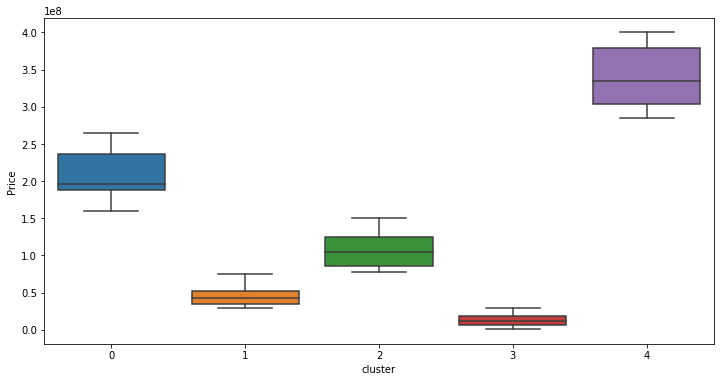

In [25]:
_ = plt.figure(figsize=(12, 6))

sns.boxplot(data=house_data, x='cluster', y='Price')

<AxesSubplot:xlabel='cluster', ylabel='Total Developed'>

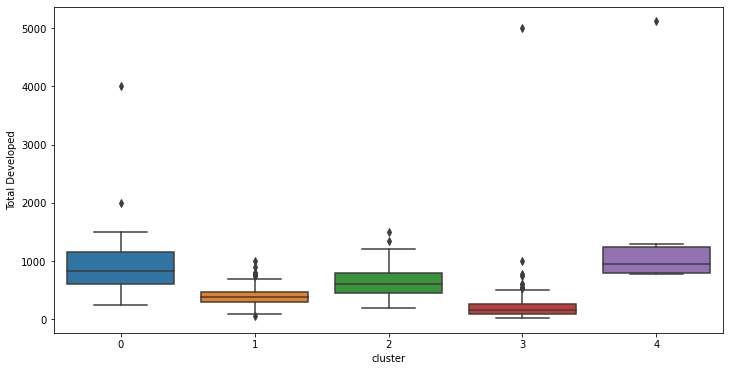

In [43]:
_ = plt.figure(figsize=(12, 6))

sns.boxplot(data=house_data, x='cluster', y='Total Developed')

### Combined

In [158]:
data_scaled = data.copy()
data_scaled[data_scaled.columns] = scaler.fit_transform(data)

data_scaled.head()

,Price,Bedrooms,Showers,Parking,Total Developed
0,0.074218,0.222222,0.50,0.333333,0.012391
1,0.025466,0.000000,0.00,0.000000,0.004175
2,0.268224,0.222222,0.75,0.333333,0.030572
3,0.136220,0.222222,0.75,0.500000,0.029091
4,0.103719,0.111111,0.25,0.333333,0.012660


In [159]:
data_scaled.describe()

,Price,Bedrooms,Showers,Parking,Total Developed
count,2269.000000,2269.000000,2269.000000,2269.000000,2269.000000
mean,0.067779,0.176975,0.317926,0.201631,0.022836
std,0.102879,0.169913,0.332308,0.211032,0.042733
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.015966,0.000000,0.000000,0.000000,0.003636
50%,0.031966,0.111111,0.250000,0.166667,0.009428
75%,0.074968,0.333333,0.500000,0.333333,0.029226
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [160]:
km = KMeans(n_clusters=5, random_state=25)
km = km.fit(data_scaled)
clusters = km.fit_predict(data_scaled)
data_scaled['cluster'] = clusters

In [161]:
data_scaled.head()

,Price,Bedrooms,Showers,Parking,Total Developed,cluster
0,0.074218,0.222222,0.50,0.333333,0.012391,2
1,0.025466,0.000000,0.00,0.000000,0.004175,4
2,0.268224,0.222222,0.75,0.333333,0.030572,0
3,0.136220,0.222222,0.75,0.500000,0.029091,0
4,0.103719,0.111111,0.25,0.333333,0.012660,1


### Compare Clusters

/Users/adem/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'Total Developed Land vs Housing Price (per cluster) - Combined'}, xlabel='Price', ylabel='Total Developed'>

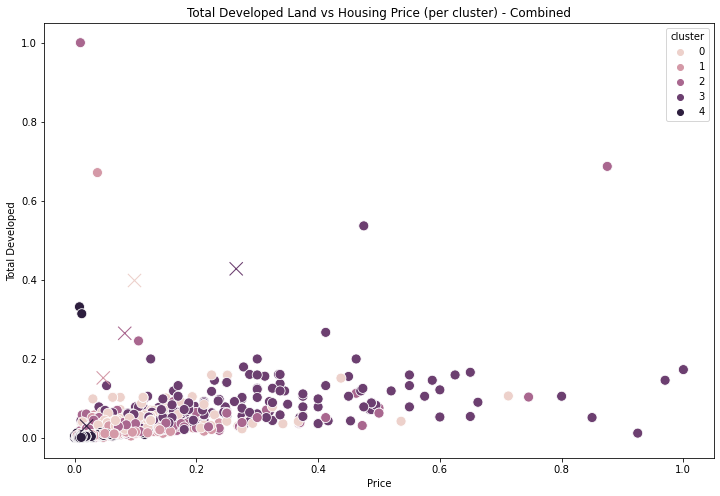

In [162]:
plt.figure(figsize=(12,8))
sns.scatterplot(data=data_scaled,s=100, x='Price', y='Total Developed', hue='cluster').set(title='Total Developed Land vs Housing Price (per cluster) - Combined')
sns.scatterplot(km.cluster_centers_[:,0],km.cluster_centers_[:,1],s=175,hue=range(5), legend=False, marker='x')

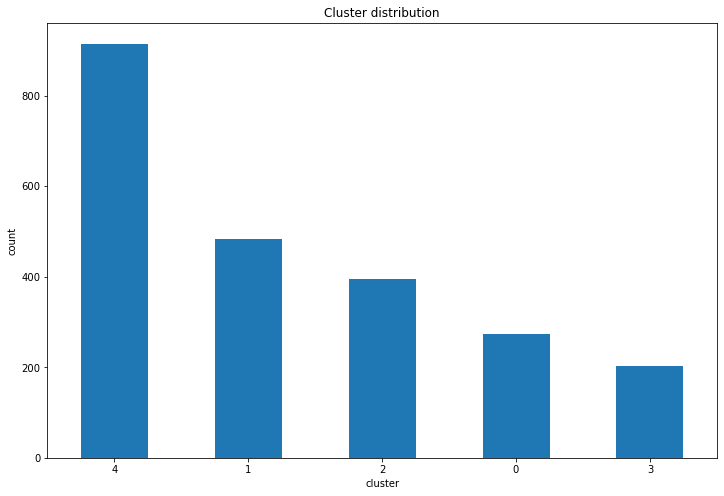

In [163]:
fig, ax = plt.subplots(1,1)
data_scaled['cluster'].value_counts().plot(kind='bar', ax=ax)
plt.xticks(rotation=0)
plt.ylabel('count')
plt.xlabel('cluster')
plt.title('Cluster distribution')
plt.show()

<AxesSubplot:xlabel='cluster', ylabel='Price'>

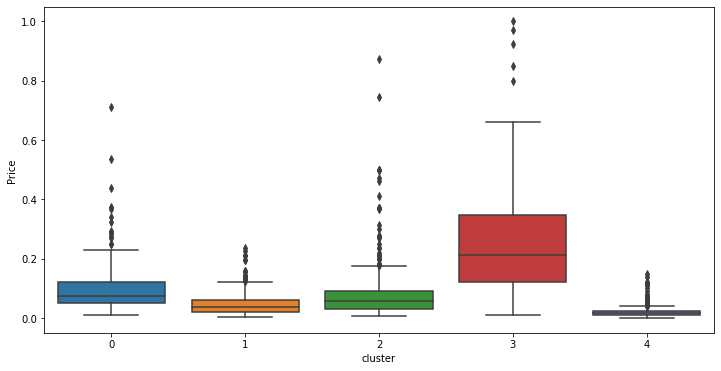

In [164]:
_ = plt.figure(figsize=(12, 6))

sns.boxplot(data=data_scaled, x='cluster', y='Price')

<AxesSubplot:xlabel='cluster', ylabel='Total Developed'>

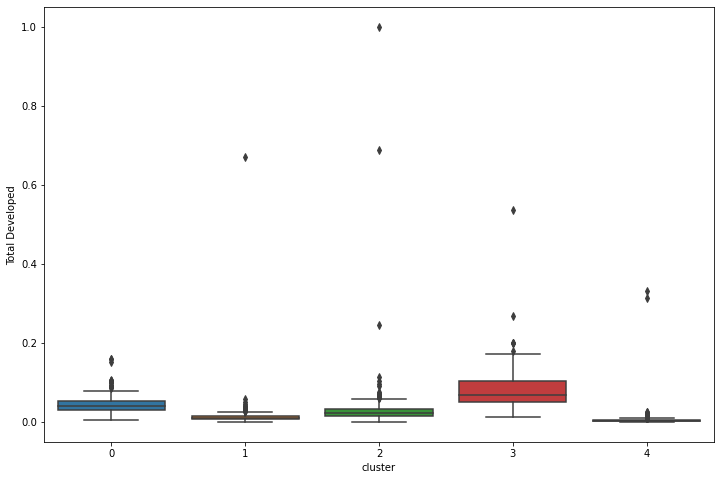

In [165]:
sns.boxplot(data=data_scaled, x='cluster', y='Total Developed')

#### Actual values

In [44]:
km = KMeans(n_clusters=5, random_state=25)
km = km.fit(data)
clusters = km.fit_predict(data)
data['cluster'] = clusters

/var/folders/b5/583sbyw12yqf8bss252d8ndc0000gn/T/ipykernel_5431/2540832695.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cluster'] = clusters


/Users/adem/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'Total Developed Land vs Housing Price (per cluster) - Combined'}, xlabel='Price', ylabel='Total Developed'>

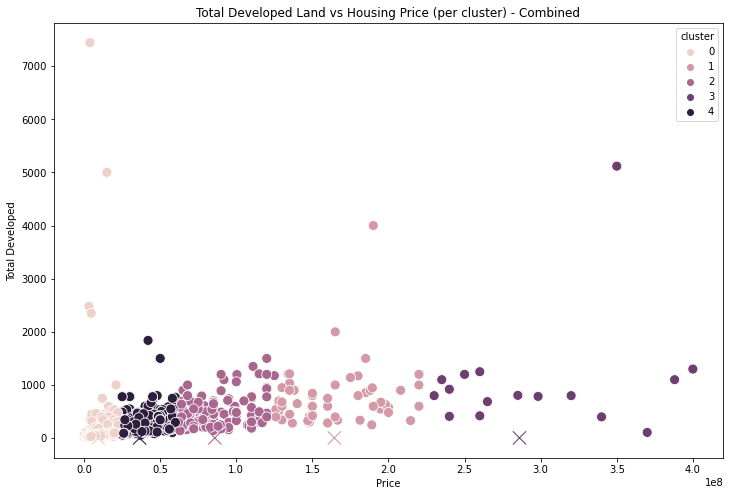

In [45]:
plt.figure(figsize=(12,8))
sns.scatterplot(data=data,s=100, x='Price', y='Total Developed', hue='cluster').set(title='Total Developed Land vs Housing Price (per cluster) - Combined')
sns.scatterplot(km.cluster_centers_[:,0],km.cluster_centers_[:,1],s=175,hue=range(5), legend=False, marker='x')

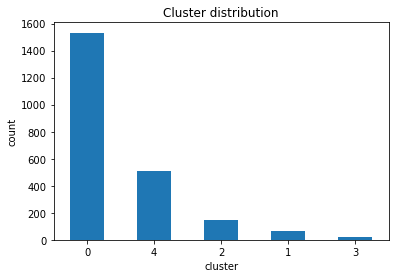

In [46]:
fig, ax = plt.subplots(1,1)
data['cluster'].value_counts().plot(kind='bar', ax=ax)
plt.xticks(rotation=0)
plt.ylabel('count')
plt.xlabel('cluster')
plt.title('Cluster distribution')
plt.show()

<AxesSubplot:xlabel='cluster', ylabel='Price'>

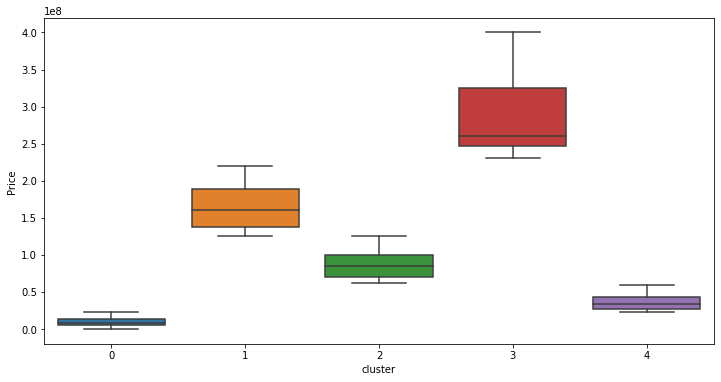

In [47]:
_ = plt.figure(figsize=(12, 6))

sns.boxplot(data=data, x='cluster', y='Price')

<AxesSubplot:xlabel='cluster', ylabel='Total Developed'>

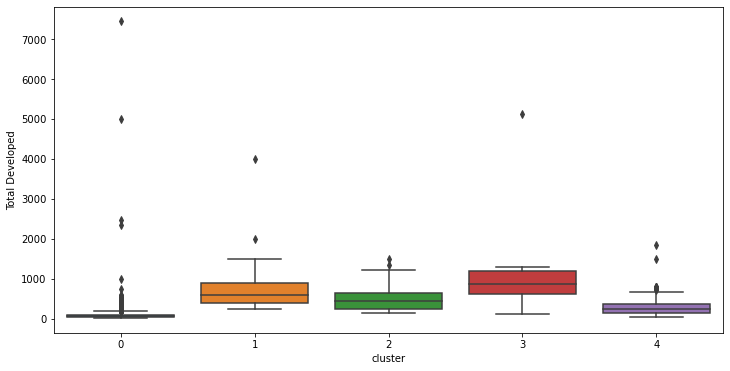

In [48]:
_ = plt.figure(figsize=(12, 6))

sns.boxplot(data=data, x='cluster', y='Total Developed')